# Neural networks code and tests notebook

# This notebook takes the flux, photon index and fratio data and try to predict classes from this data on a :

# - LSTM network
# - ConvLSTM network
# - Conv1D network

In [69]:
import numpy as np
from numpy import random
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from scipy import interpolate
import sys 
from re import search
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import glob
from datetime import datetime
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization
from keras.layers.convolutional import MaxPooling1D
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,LSTM
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
import sktime
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from kerashypetune import KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [95]:
pathON="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/ON_data/"
pathOFF="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/OFF_data/"

In [96]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f):
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)        

In [97]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)
        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON


In [130]:
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Labels = []

nbfeatures=1
nb_dels=10
a=binning-nb_dels
b=nbfeatures

c=lg

# multivariate

data_matrix= np.zeros((b,c,a))
delete=np.arange(nb_dels)

#Construct data matrix
for j in range(len(dataOFF)):

    dataframe=pd.read_csv(dataOFF[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    flux=np.array(dataframe['Flux'])
    flux=np.delete(flux,delete)
    photon_idx=np.array(dataframe['Photon Index'])
    photon_idx=np.delete(photon_idx,delete)
    flux_idx=np.array(photon_idx*flux)
    
#     data_matrix[0][j]=pd.Series(flux)
    data_matrix[0][j]=pd.Series(photon_idx)
#     data_matrix[0][j]=pd.Series(flux_idx)
    
for j in range(len(dataON)):

    v=j+len(dataOFF)
    dataframe=pd.read_csv(dataON[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    flux=np.array(dataframe['Flux'])
    flux=np.delete(flux,delete)
    photon_idx=np.array(dataframe['Photon Index'])
    photon_idx=np.delete(photon_idx,delete)
    flux_idx=np.array(photon_idx*flux)
    
#     data_matrix[0][v]=pd.Series(flux)
    data_matrix[0][v]=pd.Series(photon_idx)
#     data_matrix[0][v]=pd.Series(flux_idx)
    
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))

#Reshaping data matrix
data_matrix=data_matrix.reshape(c,a)   


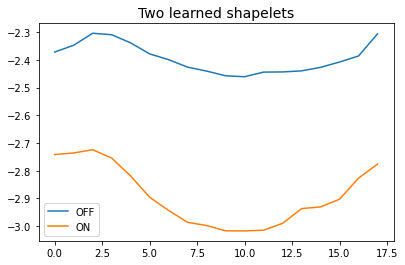

In [101]:
from pyts.classification import LearningShapelets
from pyts.utils import windowed_view

# Load the data set and fit the classifier

clf = LearningShapelets(random_state=8, tol=0.001,class_weight= {0: weight_for_0, 1: weight_for_1},shapelet_scale =7)
clf.fit(data_matrix, Labels)

# Select two shapelets
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

# Derive the distances between the time series and the shapelets
shapelet_size = shapelets.shape[1]

plt.figure(figsize=(14, 4))

# Plot the two shapelets
plt.subplot(1, 2, 1)
plt.plot(shapelets[0],label='OFF')
plt.plot(shapelets[1],label='ON')
plt.title('Two learned shapelets', fontsize=14)
plt.legend()
plt.show()

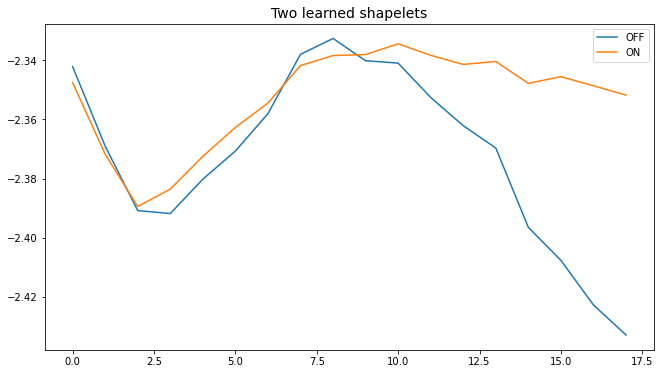

In [131]:
from pyts.classification import LearningShapelets
from pyts.utils import windowed_view
iteration=100
# Load the data set and fit the classifier
shapeletsOFF=[]
shapeletsON=[]
for i in range(iteration):
    
    clf = LearningShapelets(random_state=i, tol=0.001,class_weight= {0: weight_for_0, 1: weight_for_1},shapelet_scale =7)
    clf.fit(data_matrix, Labels)

    # Select two shapelets
    shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])
    
        
    shapeletsOFF.append(shapelets[0])
    
    shapeletsON.append(shapelets[1])
    

meanshapeletON=[]
meanshapeletOFF=[]
for j in range(len(shapelets[0])):
    pointON=0
    pointOFF=0
    for i in range(iteration):
    
        pointON+=shapeletsON[i][j]
        pointOFF+=shapeletsOFF[i][j]
    meanshapeletON.append(pointON/iteration)
    meanshapeletOFF.append(pointOFF/iteration)
    
plt.figure(figsize=((24,6)))    
plt.subplot(1, 2, 1)
plt.plot(meanshapeletOFF,label='OFF')
plt.plot(meanshapeletON,label='ON')
plt.title('Two learned shapelets', fontsize=14)
plt.legend()
plt.show()

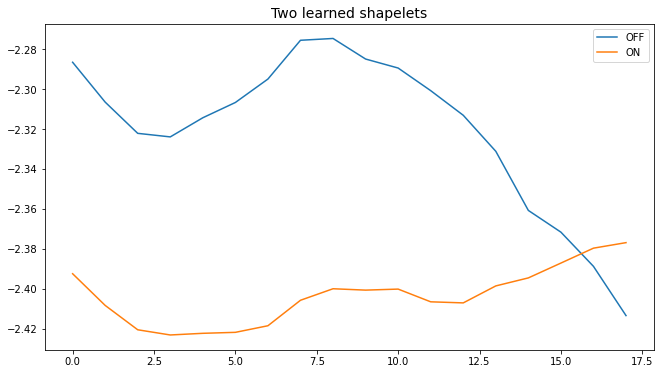

In [129]:
plt.figure(figsize=((24,6)))
plt.subplot(1, 2, 1)
plt.plot(meanshapeletOFF,label='OFF')
plt.plot(meanshapeletON,label='ON')
plt.title('Two learned shapelets', fontsize=14)
plt.legend()
plt.show()

In [198]:
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Labels = []

nbfeatures=1
nb_dels=0
a=binning-nb_dels
b=nbfeatures

c=lg

# multivariate

data_matrix= np.zeros((b,c,a))
delete=np.arange(nb_dels)

#Construct data matrix
for j in range(len(dataOFF)):

    dataframe=pd.read_csv(dataOFF[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    flux=np.array(dataframe['Flux'])
    flux=np.delete(flux,delete)
    photon_idx=np.array(dataframe['Photon Index'])
    photon_idx=np.delete(photon_idx,delete)
    flux_idx=np.array(photon_idx*flux)
    
#     data_matrix[0][j]=pd.Series(flux)
#     data_matrix[0][j]=pd.Series(photon_idx)
    data_matrix[0][j]=pd.Series(flux_idx)
    
for j in range(len(dataON)):

    v=j+len(dataOFF)
    dataframe=pd.read_csv(dataON[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    flux=np.array(dataframe['Flux'])
    flux=np.delete(flux,delete)
    photon_idx=np.array(dataframe['Photon Index'])
    photon_idx=np.delete(photon_idx,delete)
    flux_idx=np.array(photon_idx*flux)
    
#     data_matrix[0][v]=pd.Series(flux)
#     data_matrix[0][v]=pd.Series(photon_idx)
    data_matrix[0][v]=pd.Series(flux_idx)
    
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))

#Reshaping data matrix
data_matrix=data_matrix.reshape(c,a)   


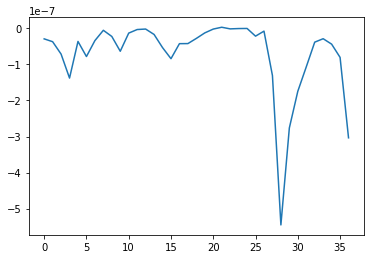

In [199]:
plt.plot(data_matrix[-2])

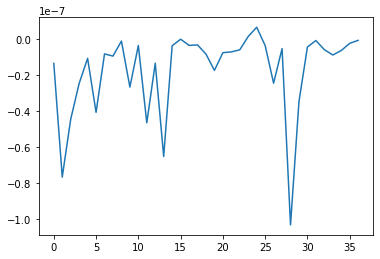

In [200]:
plt.plot(data_matrix[-3])

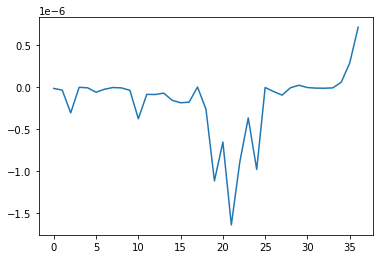

In [201]:
plt.plot(data_matrix[-4])

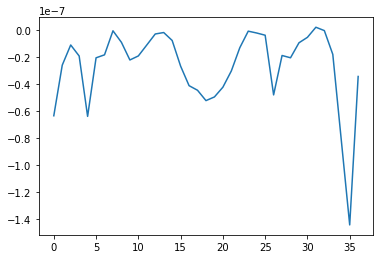

In [225]:
plt.plot(data_matrix[-18])

In [197]:
acc=[]
for i in range(15):
    
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.2, random_state=i)
    clf = LearningShapelets(random_state=42, tol=0.001,class_weight= {0: weight_for_0, 1: weight_for_1},shapelet_scale =7)
    clf.fit(x_train, y_train)

    
    prediction= clf.predict(x_test)
    predicted_labels=[]

    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test,prediction,average='weighted')
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FNEG) ,"%")
print("False Negative rate: ",np.mean(FPOS) ,"%")
print("F1 score: ",np.mean(fscore))

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


SystemError: CPUDispatcher(<function _compute_shapelet_grad at 0x000002062B6530D0>) returned a result with an error set

In [64]:
# Conv/LSTM architecture
#LSTM architecture
from keras.layers import Conv1D
from sklearn.metrics import f1_score
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []

weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=2, verbose=0, mode='auto',baseline=None, restore_best_weights=True)




for i in range(236,237):
    
    model = Sequential()
    model.add(Dense(binning, activation='tanh', input_shape=(nbfeatures,binning),input_dim=nbfeatures))
    model.add(Conv1D(filters=20, kernel_size=1, activation='tanh'))
    model.add(LSTM(20,input_shape=(20, nbfeatures), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(reduction='none'),optimizer='SGD', metrics=['binary_accuracy'])
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.1, random_state=i)
    y_test2=y_test.copy()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fitting data
    model.fit(x_train, y_train,epochs=5,batch_size=1,class_weight=class_weight,callbacks=callback)

    print('Iteration no.',i)
    #Obtain the accuracy of prediction for each class
    prediction= model.predict(x_test)
    predicted_labels=[]
    
    for i in range(len(prediction)):
        if prediction[i][0]>0.5:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if predicted_labels[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if predicted_labels[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,predicted_labels,average='weighted')
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FNEG) ,"%")
print("False Negative rate: ",np.mean(FPOS) ,"%")
print("F1 score: ",np.mean(fscore))

Epoch 1/5


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 1, 37), found shape=(1, 27)


In [ ]:

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(params):
    
    set_seed(33)
    lgON=30
    lgOFF=1059
    lg=lgON+lgOFF
    weight_for_0 = (1 / lgOFF) * (lg / 2.0)
    weight_for_1 = (1 / lgON) * (lg / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=2, verbose=0, mode='auto',baseline=None, restore_best_weights=True)
    inp = Input(shape=(37, 3))

    x = Dense(params['units_dense'], activation=params['activ'])(inp)
    x = Conv1D(filters=params['units_conv'], kernel_size=1, activation=params['activ'],name='extractor')(x)
    x = LSTM(params['units_LSTM'], activation=params['activ'],return_sequences=True)(x)
    x = Flatten()(x)
    out = Dense(2,activation='softmax')(x)
    
    model = Model(inp, out)
    model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(reduction='none'),optimizer='SGD', metrics=['binary_accuracy'])
    
    return model

In [ ]:
param_grid = {
    'units_dense': [37,20],
    'units_conv': [37,20],
    'units_LSTM': [20, 37],
    'activ': ['relu', 'tanh']
}

callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=2, verbose=0, mode='auto',baseline=None, restore_best_weights=True)

kgs = KerasGridSearch(get_model, param_grid, 
                      monitor='binary_accuracy', greater_is_better=False, tuner_verbose=1)
kgs.search(x_train, y_train, validation_data=(x_test, y_test), callbacks=callback, epochs=5)

In [ ]:
def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]
    
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [ ]:
### GENERATE ACTIVATION ON INPUT SEQUENCE ###

activation = activation_grad(x_test[15], kgs.best_model)

plt.figure(figsize=(9,5))
plt.plot(x_test[2])
plt.twinx()
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from __future__ import print_function
# from matplotlib.backends.backend_pdf import PdfPages

get_last_conv = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-3].output])
last_conv = get_last_conv([x_test[:100], 1])[0]

get_softmax = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[-1].output])
softmax = get_softmax(([x_test[:100], 1]))[0]
softmax_weight = model.get_weights()[-2]
CAM = np.dot(last_conv, softmax_weight)


# pp = PdfPages('CAM.pdf')
for k in range(20):
    CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
    c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
    plt.figure(figsize=(13, 7));
    plt.plot(x_test[k].squeeze());
    plt.scatter(np.arange(len(x_test[k])), x_test[k].squeeze(), cmap='hot_r', c=c[k, :, :, int(y_test[k])].squeeze(), s=100);
    plt.title(
        'True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax[k][int(y_test[k])]))
    plt.colorbar();